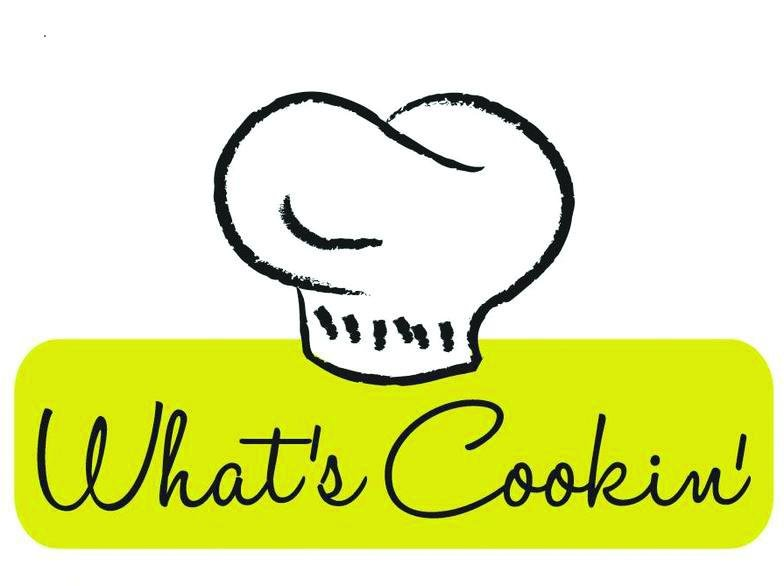

# Importing libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json

import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from wordcloud import WordCloud
from collections import Counter

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings 
warnings.filterwarnings('ignore')

# Loading the json file (train and test data)

In [ ]:
with open("/kaggle/input/whats-cooking-kernels-only/train.json") as f:
    train_json= json.load(f)
train = pd.DataFrame(train_json)

with open("/kaggle/input/whats-cooking-kernels-only/test.json") as f:
    test_json= json.load(f)
test = pd.DataFrame(test_json)

display(train.head())
display(test.head())

# Data Analysing

In [ ]:
print("Any null data:\n")
print(train.isnull().sum())

In [ ]:
raw_ingredients = [ing for ingredients in train['ingredients'] for ing in ingredients]

print("Any ingredient that is <= 2 chars only:")
display([ing for ing in raw_ingredients if len(ing) <=2])

print("\nIngredient with numbers")
x = [ing for ing in raw_ingredients if re.findall('[0-9]',ing)]
num_ing = list(set(x))
display(num_ing[1:10])

print("\nHow many such ingredients?:",len(num_ing))

print("\nSpecial characters in the ingredients:")
sp_chrs = [''.join(ing for ing in set("".join(raw_ingredients)) if re.findall('[^a-zA-Z]',ing))]
sp_chrs="".join(sp_chrs)
display(sp_chrs)
print("\nIngredients have cusine names in them:\n")

keywords = ['italian', 'mexican', 'indian', 'chinese', 'french',
       'cajun','creole', 'thai', 'japanese', 'greek', 'spanish', 'korean',
       'vietnamese', 'moroccan', 'filipino', 'irish', 'jamaican',
       'russian', 'american']

z = {}

for k in keywords:
    x = [ing for ing in raw_ingredients if k in ing]
    z[k] = set(x)
    
for key,values in z.items():
    print(key,":\n")
    print(values)
    print('\n')
    

# Data Cleaning

In [ ]:
def clean_data(data):
   
    cleandata = set()
    sw = stopwords.words('english')    
            
    pattern = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    sp_chrs = '[è’â®(î™í€çéú]'

    wordnet_lemmatizer = WordNetLemmatizer()
    data =  [word.lower() for word in data]
    
    for word in data:
        word = re.sub("[0-9]","",word) 
        word  = re.sub(pattern,'',word)
        word = re.sub(sp_chrs,'',word)

        if word not in sw and len(word) > 2:
            word = re.sub(r'(garlic cloves)','garlic', word)
                          
            x = re.sub(r'(nutritional|whole|quick|low|topping|paste|cut into|meal|food|low-fat|into|season|slice|unsalted|fat|thin|thick|pinch|chuck|liquid|packed|granul|firm|black|white|yellow|brown|blue|red|green|oz|ounc|ounce|pound|lb|inch|kilo|kg|cook|big|small|salt|water|ground|hot|cold|dried|medium|skin|crush|crumble|dice|ground|shred|grate|mince|powder|chop|peel|thaw|slice|season|plain|large|fresh|fine|boil|extra|prepare|italian|mexican|indian|chinese|french|cajun|creole|thai|japanese|greek|spanish|korean|vietnamese|moroccan|filipino|irish|jamaican|russian|american)\w*','', word)
            cleandata.add(x)
            
    return list(cleandata)

print("Cleaning Messages (train)...") 
train['Ingredients'] = train['ingredients'].apply(clean_data)

print("Cleaning Messages (test)...") 
test['Ingredients'] = test['ingredients'].apply(clean_data)

print("Done!!")

In [ ]:
def count_words(data):
    return len(data)

train['Ingredients_count'] = train['Ingredients'].apply(count_words)
test['Ingredients_count']  = test['Ingredients'].apply(count_words)

# Data Visualization
#### Top cuisines

In [ ]:
bg_color = (0.25, 0.25, 0.25)
sns.set(rc={"font.style":"normal",
            "axes.facecolor":bg_color,
            "figure.facecolor":bg_color,
            "text.color":"white",
            "xtick.color":"white",
            "ytick.color":"white",
            "axes.labelcolor":"white",
            "axes.grid":False,
            'axes.labelsize':25,
            'figure.figsize':(15.0,15.0),
            'xtick.labelsize':15,
            'ytick.labelsize':15})    

In [ ]:
cusines = train.cuisine.value_counts().index
count =  train.cuisine.value_counts()

plt.figure(figsize=(10,8));

sns.barplot(x= count,y =cusines,palette="Set1");
plt.title('Cuisines');
plt.xlabel("Count");
plt.show();

## Most and least common ingredients of each cuisine

In [ ]:
common  = Counter([item for ing in train['Ingredients'] for item in ing])

most_common = common.most_common(20)
ingd,count = [list(c) for c in zip(*most_common)]

plt.figure(figsize=(10,8));
sns.barplot(y=ingd,x=count,palette="rainbow");
plt.title('Most Common Ingredients');
plt.xlabel("Count");
plt.show();

least_common = common.most_common()[-10:]
ingd,count = [list(c) for c in zip(*least_common)]

plt.figure(figsize=(10,8));
sns.barplot(y=ingd,x=count,palette="rainbow");
plt.title('Least Common Ingredients');
plt.xlabel("Count");
plt.show();

## Cusines with maximum and minumum ingredients

In [ ]:
ingd = train[train.Ingredients_count > 45]['cuisine']
count = train[train.Ingredients_count > 45]['Ingredients_count']

plt.figure(figsize=(10,8));
sns.barplot(y=ingd,x=count,palette="Set1");
plt.suptitle('Cuisines with maximum ingredients');
plt.xlabel("");

plt.ylabel("")
plt.show();

ingd = train[train.Ingredients_count < 2]['cuisine']
count = train[train.Ingredients_count < 2]['Ingredients_count']

plt.figure(figsize=(10,8));
sns.barplot(y=ingd,x=count,palette="Set2");
plt.suptitle('Cuisines with miniumum ingredients');
plt.xlabel("")
plt.ylabel("")
plt.show();


## Top ingredients in few cuisines
### Italian

In [ ]:
cuisine  = train[train['cuisine']=='italian'].reset_index()
name = []
for i in range(0,len(cuisine)):
    text = cuisine['Ingredients'][i]
    text = ','.join(text)
    name.append(text)
    text = ' '.join(name)
wc = WordCloud(width = 800, height = 400, background_color ='white', 
                min_font_size = 14).generate(text)                  
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wc) 
plt.axis('off') 
plt.title("Italian Cuisine")
plt.show()


## Indian

In [ ]:
cuisine  = train[train['cuisine']=='indian'].reset_index()
name = []
for i in range(0,len(cuisine)):
    text = cuisine['Ingredients'][i]
    text = ','.join(text)
    name.append(text)
    text = ' '.join(name)
wc = WordCloud(width = 800, height = 400, background_color ='white', 
                min_font_size = 14).generate(text)                  
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wc) 
plt.title("Indian Cuisine")
plt.axis('off') 
plt.show()

In [ ]:
def count_ingredients(data):    
    return dict(pd.Series(data).value_counts())

all_ingredients = train.groupby('cuisine')['Ingredients'].sum()

ingredients_count = all_ingredients.apply(count_ingredients)

top10 =pd.Series()

for cuisine, list_ingredients in ingredients_count.items():
    count=0
    top10[cuisine] = []    
    for ingredient, occurance in pd.Series(list_ingredients)[:25].items():
        if count == 10:
            break
        ingredient = ingredient.strip()
        if ingredient != '' and ingredient not in top10[cuisine]:
            top10[cuisine].append(ingredient)
            count+=1
df_top10 = pd.DataFrame.from_items(zip(top10.index, top10.values)).T

df_top10.columns = ['top{}'.format(i) for i in range(1, 11)]
print("Top 10 ingredients of each cuisine")
df_top10.style

In [ ]:
# Convert list of strings to string
def convert_list_to_string(data):
    return ' '.join(data)

train['Ingredients'] = train['Ingredients'].apply(convert_list_to_string)
test['Ingredients'] = test['Ingredients'].apply(convert_list_to_string)

In [ ]:
tf = TfidfVectorizer()
#cv = CountVectorizer()

bow_train_data= tf.fit_transform(train['Ingredients'])
print(bow_train_data.shape)

bow_test_data = tf.transform(test['Ingredients'])
print(bow_test_data.shape)

In [ ]:
le = LabelEncoder()
train['cuisine'] = le.fit_transform(train['cuisine'])

In [ ]:
train_data,test_data,train_label,test_label = train_test_split(bow_train_data,train['cuisine'].values,stratify=train['cuisine'].values,test_size=0.3,random_state=5)

train_data.shape,test_data.shape,train_label.shape,test_label.shape

In [ ]:
# Unigram model and parameters for the models are not tuned
vclf=VotingClassifier(estimators=[('lr',LogisticRegression(random_state = 42)),
                                  ('svc',SVC(kernel='linear',random_state = 42,probability=True)),
                                  ('rfc',RandomForestClassifier(n_estimators = 500,random_state = 42))], 
                                    voting='soft', weights = [1,1,1]) 
vclf.fit(train_data, train_label)

In [ ]:

final_pred = vclf.predict(bow_test_data) 
cuisine = le.inverse_transform(final_pred)

sub = pd.DataFrame({'id': test['id'], 'cuisine': cuisine}, columns=['id', 'cuisine'])
sub.to_csv('submission.csv', index = False)